# L-Layers Neural Network from scratch

## Cats vs non-Cats Dataset

### Import

In [1]:
import numpy as np
import h5py
import gc

train_set = h5py.File('data/cats/train.h5')
train_X_orig = np.array(train_set["train_set_x"])
train_Y_orig = np.array(train_set["train_set_y"])
del train_set
col = gc.collect()

### Explore

In [2]:
print(f"There are {len(train_X_orig)} training images")
print(f"Each image has shape {train_X_orig[0].shape}")

There are 209 training images
Each image has shape (64, 64, 3)


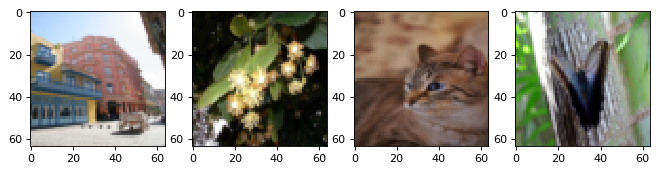

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6), dpi=80)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(train_X_orig[np.random.randint(len(train_X_orig))])

### Preprocess

In [4]:
def flatten(imgs):
    return imgs.reshape(imgs.shape[0], -1).T

train_X = flatten(train_X_orig)
print("Training images have now shape", train_X.shape)

Training images have now shape (12288, 209)


In [5]:
train_X = train_X/255

In [6]:
train_Y = train_Y_orig.reshape(1,-1)
print("Training Labels have now shape", train_Y.shape)

Training Labels have now shape (1, 209)


## Build the Neural Network Architecture + Parameter Initialization

In [7]:
LAYERS_DIMS = [train_X.shape[0],20,7,5,1]          # Number of Neurons in each layer
ACTIVATIONS = {1: "relu", 2: "relu", 3: "relu", 4: "sigmoid"} # Activation function type for each layer

L = len(LAYERS_DIMS) # Number of layers
print("Layers Dimensions: ", LAYERS_DIMS)
print("Activations for hidden layers + output layer : ", ACTIVATIONS)

Layers Dimensions:  [12288, 20, 7, 5, 1]
Activations for hidden layers + output layer :  {1: 'relu', 2: 'relu', 3: 'relu', 4: 'sigmoid'}


In [8]:
def init_params(layers_dims):
    params = {}
    
    
    np.random.seed(1)
    for i in range(1, L):
        params["W" + str(i)] = np.random.randn(LAYERS_DIMS[i], LAYERS_DIMS[i-1]) / np.sqrt(LAYERS_DIMS[i-1])
        #limit = np.sqrt(6/(LAYERS_DIMS[i-1] + LAYERS_DIMS[i]))
        #params["W" + str(i)] = np.random.uniform(low=-limit, high=limit, size=(LAYERS_DIMS[i],LAYERS_DIMS[i-1]))
        params["b" + str(i)] = np.zeros((LAYERS_DIMS[i], 1))
    return params

parameters = init_params(LAYERS_DIMS)

print("Parameters: ")
for k,v in parameters.items():
    print(k,v.shape)

Parameters: 
W1 (20, 12288)
b1 (20, 1)
W2 (7, 20)
b2 (7, 1)
W3 (5, 7)
b3 (5, 1)
W4 (1, 5)
b4 (1, 1)


## Forward Propagation

In [9]:
def activation(function_name, arg):

    if function_name == "relu":
        arg[arg <= 0] = 0
        return arg

    elif function_name == 'sigmoid':
        return 1/(1 + np.exp(-arg))

    else:
        raise ValueError("Unknown Activation Function name !")

rm = np.random.randn(3,3)
print(rm)
print(activation("relu", rm))

[[ 0.61572715  0.47912853 -0.11148172]
 [ 0.85431113 -0.23064886 -1.63209627]
 [ 0.03271553 -0.05120898 -0.33643879]]
[[0.61572715 0.47912853 0.        ]
 [0.85431113 0.         0.        ]
 [0.03271553 0.         0.        ]]


In [10]:
def forward_propagate(X, params):
    As = {}
    Zs = {}
    
    As[0] = X
    for i in range(1, L):
        Z = np.dot(params["W" + str(i)], As[i-1]) + params["b" + str(i)]
        A = activation(ACTIVATIONS[i], Z)
        
        Zs[i] = Z
        As[i] = A

    assert As[1].shape == (LAYERS_DIMS[1], X.shape[1]), f"Problem with shape of As As[1] has shape {As[1].shape}"
    
    return As, Zs

As, Zs = forward_propagate(train_X, parameters)


## Loss Computation

In [11]:
def cost(preds, ys):
    #print(preds.shape, ys.shape)
    m = preds.shape[1]
    
    c = -1/m * (np.dot(ys, np.log(preds).T) + np.dot((1-ys), np.log(1-preds).T))
    return np.squeeze(c)

## Backward Propagation

In [12]:
def activation_prime(function_name, arg):
    if function_name == "relu":
        arg[arg<=0] = 0
        arg[arg>0] = 1
        return arg

    elif function_name == 'sigmoid':
        return activation(function_name, arg) * (1 - activation(function_name, arg))

    else:
        raise ValueError("Unknown Activation Function name !")

In [13]:
def back_propagate(params, As, Zs):
    grads = {}
    m = As[1].shape[1]

    dA_prev = - ( np.divide(train_Y, As[L-1]) -  np.divide(1 - train_Y, 1 - As[L-1]) ) # derivative of the cost with respect to predictions (A_prev here)
    
    for l in reversed(range(1,L)):
        #print("Layer ", l, ACTIVATIONS[l])
        # Step 1: Compute dZ
        #print("dA_prev", dA_prev.shape)
        dZ = np.multiply(dA_prev, activation_prime(ACTIVATIONS[l], Zs[l]))
        #print("dZ: ", dZ.shape)
        
        # Step 2: Compute gradients
        dW = 1/m * np.dot(dZ, As[l-1].T)
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(parameters["W" + str(l)].T, dZ)
        
        grads["dW" + str(l)] = dW
        grads["db" + str(l)] = db
    
    # Check shape of gradients is OK
    random_index = np.random.randint(1,L)
    assert parameters["W" + str(random_index)].shape == grads["dW" + str(random_index)].shape, "Problem with shape of Gradients !"
    
    return grads

In [14]:
grads = back_propagate(parameters, As, Zs)
print("Grads: ")
for k,v in grads.items():
    print(k, v.shape)

Grads: 
dW4 (1, 5)
db4 (1, 1)
dW3 (5, 7)
db3 (5, 1)
dW2 (7, 20)
db2 (7, 1)
dW1 (20, 12288)
db1 (20, 1)


## Update Parameters

In [15]:
def update_parameters(grads, params, learning_rate=0.075):
    for l in range(1,L):
        params["W" + str(l)] = params["W" + str(l)] - learning_rate*grads["dW" + str(l)]
        params["b" + str(l)] = params["b" + str(l)] - learning_rate*grads["db" + str(l)]
    return params

parameters = update_parameters(grads, parameters)

print("Parameters: ")
for k,v in parameters.items():
    print(k,v.shape)

Parameters: 
W1 (20, 12288)
b1 (20, 1)
W2 (7, 20)
b2 (7, 1)
W3 (5, 7)
b3 (5, 1)
W4 (1, 5)
b4 (1, 1)


## Train the Network

In [16]:
LAYERS_DIMS = [train_X.shape[0],20,7,5,1]          # Number of Neurons in each layer
ACTIVATIONS = {1: "relu", 2: "relu", 3: "relu", 4: "sigmoid"} # Activation function type for each layer

L = len(LAYERS_DIMS) # Number of layers
print("Layers Dimensions: ", LAYERS_DIMS)
print("Activations for hidden layers + output layer : ", ACTIVATIONS)

Layers Dimensions:  [12288, 20, 7, 5, 1]
Activations for hidden layers + output layer :  {1: 'relu', 2: 'relu', 3: 'relu', 4: 'sigmoid'}


In [17]:
parameters = init_params(LAYERS_DIMS)

print("Training the network ...")
num_iter = 2500
for i in range(num_iter):
    As, Zs = forward_propagate(train_X, parameters)
    if i % 100 == 0 :
        print(i, " Cost: ", cost(As[L-1], train_Y))
    grads = back_propagate(parameters, As, Zs)
    parameters = update_parameters(grads, parameters, learning_rate=0.0075)

Training the network ...
0  Cost:  0.7717493284237686
100  Cost:  0.6720534400822914
200  Cost:  0.6482632048575212
300  Cost:  0.6115068816101356
400  Cost:  0.5670473268366112
500  Cost:  0.54013766345478
600  Cost:  0.5279299569455267
700  Cost:  0.4654773771766851
800  Cost:  0.36912585249592794
900  Cost:  0.39174697434805356
1000  Cost:  0.3151869888600617
1100  Cost:  0.2726998441789385
1200  Cost:  0.23741853400268137
1300  Cost:  0.19960120532208647
1400  Cost:  0.18926300388463302
1500  Cost:  0.1611885466582775
1600  Cost:  0.14821389662363318
1700  Cost:  0.13777487812972944
1800  Cost:  0.1297401754919012
1900  Cost:  0.12122535068005211
2000  Cost:  0.11382060668633713
2100  Cost:  0.10783928526254133
2200  Cost:  0.1028546606935268
2300  Cost:  0.10089745445261787
2400  Cost:  0.09287821526472395


In [18]:
test_set = h5py.File('data/cats/test.h5')
test_X_orig = np.array(test_set["test_set_x"])
test_Y_orig = np.array(test_set["test_set_y"])
del test_set
col = gc.collect()
test_X = flatten(test_X_orig)
print("testing images have now shape", test_X.shape)
test_X = test_X/255
test_Y = test_Y_orig.reshape(1,-1)
print("testing Labels have now shape", test_Y.shape)

testing images have now shape (12288, 50)
testing Labels have now shape (1, 50)


In [19]:
def predict(X, Y, params):
    As, _ = forward_propagate(X, params)
    return (As[L-1] > .5)

In [20]:
preds = predict(test_X, test_Y, parameters)
accuracy = (np.sum(preds == test_Y)/test_Y.shape[1]) * 100
print("Accuracy: ", accuracy, '%')

Accuracy:  80.0 %


## Same Model with Keras

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import initializers

#my_init = initializers.he_uniform(seed=11)
def my_init(shape, dtype=None):
    np.random.seed(1)
    return (np.random.randn(shape[0], shape[1]) / np.sqrt(shape[1]))

def run_keras():
    model=Sequential()
    act='relu'
    model.add(Dense(20,input_shape=(train_X.shape[0],), activation=act, kernel_initializer=my_init)) 
    model.add(Dense(7,activation=act , kernel_initializer=my_init))
    model.add(Dense(5,activation=act , kernel_initializer=my_init))
    model.add(Dense(1,activation='sigmoid' , kernel_initializer=my_init))
    model.compile(SGD(lr=0.0075),'binary_crossentropy',metrics=['binary_accuracy'])
    history = model.fit( train_X.T, train_Y.T, batch_size=train_X.shape[1], epochs=2500, verbose=1 )
    preds = model.predict(test_X.T)
    loss = history.history['loss']
    return preds, loss[-1]

ps, l = run_keras()

Using TensorFlow backend.


Epoch 1/2400
209/209 [==============================] - 1s 3ms/step - loss: 1.4350 - binary_accuracy: 0.5837
Epoch 2/2400
209/209 [==============================] - 0s 363us/step - loss: 1.4066 - binary_accuracy: 0.5311
Epoch 3/2400
209/209 [==============================] - 0s 152us/step - loss: 1.4822 - binary_accuracy: 0.5981
Epoch 4/2400
209/209 [==============================] - 0s 179us/step - loss: 1.5222 - binary_accuracy: 0.5072
Epoch 5/2400
209/209 [==============================] - 0s 150us/step - loss: 1.7758 - binary_accuracy: 0.6172
Epoch 6/2400
209/209 [==============================] - 0s 170us/step - loss: 1.3552 - binary_accuracy: 0.5120
Epoch 7/2400
209/209 [==============================] - 0s 180us/step - loss: 1.5738 - binary_accuracy: 0.6316
Epoch 8/2400
209/209 [==============================] - 0s 187us/step - loss: 1.2583 - binary_accuracy: 0.5167
Epoch 9/2400
209/209 [==============================] - 0s 202us/step - loss: 1.4197 - binary_accuracy: 0.6268
Epo

Epoch 75/2400
209/209 [==============================] - 0s 173us/step - loss: 0.6132 - binary_accuracy: 0.6746
Epoch 76/2400
209/209 [==============================] - 0s 164us/step - loss: 0.6119 - binary_accuracy: 0.6746
Epoch 77/2400
209/209 [==============================] - 0s 162us/step - loss: 0.6107 - binary_accuracy: 0.6746
Epoch 78/2400
209/209 [==============================] - 0s 186us/step - loss: 0.6094 - binary_accuracy: 0.6746
Epoch 79/2400
209/209 [==============================] - 0s 184us/step - loss: 0.6082 - binary_accuracy: 0.6746
Epoch 80/2400
209/209 [==============================] - 0s 185us/step - loss: 0.6071 - binary_accuracy: 0.6794
Epoch 81/2400
209/209 [==============================] - 0s 140us/step - loss: 0.6060 - binary_accuracy: 0.6794
Epoch 82/2400
209/209 [==============================] - 0s 144us/step - loss: 0.6048 - binary_accuracy: 0.6746
Epoch 83/2400
209/209 [==============================] - 0s 150us/step - loss: 0.6038 - binary_accuracy:

Epoch 148/2400
209/209 [==============================] - 0s 171us/step - loss: 0.5599 - binary_accuracy: 0.7081
Epoch 149/2400
209/209 [==============================] - 0s 156us/step - loss: 0.5594 - binary_accuracy: 0.7033
Epoch 150/2400
209/209 [==============================] - 0s 154us/step - loss: 0.5589 - binary_accuracy: 0.7081
Epoch 151/2400
209/209 [==============================] - 0s 177us/step - loss: 0.5584 - binary_accuracy: 0.7033
Epoch 152/2400
209/209 [==============================] - 0s 157us/step - loss: 0.5579 - binary_accuracy: 0.7129
Epoch 153/2400
209/209 [==============================] - 0s 190us/step - loss: 0.5575 - binary_accuracy: 0.7033
Epoch 154/2400
209/209 [==============================] - 0s 168us/step - loss: 0.5569 - binary_accuracy: 0.7129
Epoch 155/2400
209/209 [==============================] - 0s 196us/step - loss: 0.5565 - binary_accuracy: 0.7033
Epoch 156/2400
209/209 [==============================] - 0s 146us/step - loss: 0.5559 - binary_

Epoch 221/2400
209/209 [==============================] - 0s 164us/step - loss: 0.5250 - binary_accuracy: 0.7177
Epoch 222/2400
209/209 [==============================] - 0s 156us/step - loss: 0.5246 - binary_accuracy: 0.7273
Epoch 223/2400
209/209 [==============================] - 0s 190us/step - loss: 0.5241 - binary_accuracy: 0.7273
Epoch 224/2400
209/209 [==============================] - 0s 171us/step - loss: 0.5237 - binary_accuracy: 0.7129
Epoch 225/2400
209/209 [==============================] - 0s 171us/step - loss: 0.5233 - binary_accuracy: 0.7225
Epoch 226/2400
209/209 [==============================] - 0s 193us/step - loss: 0.5228 - binary_accuracy: 0.7129
Epoch 227/2400
209/209 [==============================] - 0s 159us/step - loss: 0.5224 - binary_accuracy: 0.7273
Epoch 228/2400
209/209 [==============================] - 0s 141us/step - loss: 0.5220 - binary_accuracy: 0.7129
Epoch 229/2400
209/209 [==============================] - 0s 132us/step - loss: 0.5216 - binary_

Epoch 294/2400
209/209 [==============================] - 0s 159us/step - loss: 0.4973 - binary_accuracy: 0.7368
Epoch 295/2400
209/209 [==============================] - 0s 135us/step - loss: 0.4970 - binary_accuracy: 0.7751
Epoch 296/2400
209/209 [==============================] - 0s 196us/step - loss: 0.4977 - binary_accuracy: 0.7368
Epoch 297/2400
209/209 [==============================] - 0s 159us/step - loss: 0.4979 - binary_accuracy: 0.7703
Epoch 298/2400
209/209 [==============================] - 0s 168us/step - loss: 0.4988 - binary_accuracy: 0.7368
Epoch 299/2400
209/209 [==============================] - 0s 188us/step - loss: 0.4985 - binary_accuracy: 0.7751
Epoch 300/2400
209/209 [==============================] - 0s 202us/step - loss: 0.4996 - binary_accuracy: 0.7368
Epoch 301/2400
209/209 [==============================] - 0s 152us/step - loss: 0.4988 - binary_accuracy: 0.7799
Epoch 302/2400
209/209 [==============================] - 0s 147us/step - loss: 0.5002 - binary_

Epoch 367/2400
209/209 [==============================] - 0s 155us/step - loss: 0.4607 - binary_accuracy: 0.8038
Epoch 368/2400
209/209 [==============================] - 0s 156us/step - loss: 0.4616 - binary_accuracy: 0.7368
Epoch 369/2400
209/209 [==============================] - 0s 169us/step - loss: 0.4606 - binary_accuracy: 0.8086
Epoch 370/2400
209/209 [==============================] - 0s 164us/step - loss: 0.4612 - binary_accuracy: 0.7368
Epoch 371/2400
209/209 [==============================] - 0s 179us/step - loss: 0.4597 - binary_accuracy: 0.8134
Epoch 372/2400
209/209 [==============================] - 0s 181us/step - loss: 0.4604 - binary_accuracy: 0.7368
Epoch 373/2400
209/209 [==============================] - 0s 165us/step - loss: 0.4595 - binary_accuracy: 0.8134
Epoch 374/2400
209/209 [==============================] - 0s 165us/step - loss: 0.4610 - binary_accuracy: 0.7368
Epoch 375/2400
209/209 [==============================] - 0s 212us/step - loss: 0.4598 - binary_

Epoch 440/2400
209/209 [==============================] - 0s 155us/step - loss: 0.4225 - binary_accuracy: 0.7703
Epoch 441/2400
209/209 [==============================] - 0s 155us/step - loss: 0.4209 - binary_accuracy: 0.8373
Epoch 442/2400
209/209 [==============================] - 0s 178us/step - loss: 0.4215 - binary_accuracy: 0.7703
Epoch 443/2400
209/209 [==============================] - 0s 184us/step - loss: 0.4200 - binary_accuracy: 0.8373
Epoch 444/2400
209/209 [==============================] - 0s 141us/step - loss: 0.4198 - binary_accuracy: 0.7703
Epoch 445/2400
209/209 [==============================] - 0s 165us/step - loss: 0.4183 - binary_accuracy: 0.8373
Epoch 446/2400
209/209 [==============================] - 0s 166us/step - loss: 0.4182 - binary_accuracy: 0.7751
Epoch 447/2400
209/209 [==============================] - 0s 179us/step - loss: 0.4170 - binary_accuracy: 0.8373
Epoch 448/2400
209/209 [==============================] - 0s 153us/step - loss: 0.4168 - binary_

Epoch 513/2400
209/209 [==============================] - 0s 138us/step - loss: 0.4100 - binary_accuracy: 0.8278
Epoch 514/2400
209/209 [==============================] - 0s 180us/step - loss: 0.4127 - binary_accuracy: 0.7847
Epoch 515/2400
209/209 [==============================] - 0s 139us/step - loss: 0.4065 - binary_accuracy: 0.8325
Epoch 516/2400
209/209 [==============================] - 0s 135us/step - loss: 0.4079 - binary_accuracy: 0.7943
Epoch 517/2400
209/209 [==============================] - 0s 151us/step - loss: 0.4026 - binary_accuracy: 0.8230
Epoch 518/2400
209/209 [==============================] - 0s 134us/step - loss: 0.4048 - binary_accuracy: 0.7943
Epoch 519/2400
209/209 [==============================] - 0s 167us/step - loss: 0.3999 - binary_accuracy: 0.8230
Epoch 520/2400
209/209 [==============================] - 0s 152us/step - loss: 0.4025 - binary_accuracy: 0.7943
Epoch 521/2400
209/209 [==============================] - 0s 160us/step - loss: 0.3974 - binary_

Epoch 586/2400
209/209 [==============================] - 0s 164us/step - loss: 0.3531 - binary_accuracy: 0.8278
Epoch 587/2400
209/209 [==============================] - 0s 178us/step - loss: 0.3526 - binary_accuracy: 0.8421
Epoch 588/2400
209/209 [==============================] - 0s 178us/step - loss: 0.3520 - binary_accuracy: 0.8278
Epoch 589/2400
209/209 [==============================] - 0s 191us/step - loss: 0.3515 - binary_accuracy: 0.8421
Epoch 590/2400
209/209 [==============================] - 0s 163us/step - loss: 0.3506 - binary_accuracy: 0.8278
Epoch 591/2400
209/209 [==============================] - 0s 157us/step - loss: 0.3488 - binary_accuracy: 0.8565
Epoch 592/2400
209/209 [==============================] - 0s 191us/step - loss: 0.3478 - binary_accuracy: 0.8230
Epoch 593/2400
209/209 [==============================] - 0s 150us/step - loss: 0.3456 - binary_accuracy: 0.8565
Epoch 594/2400
209/209 [==============================] - 0s 173us/step - loss: 0.3440 - binary_

Epoch 659/2400
209/209 [==============================] - 0s 155us/step - loss: 0.3157 - binary_accuracy: 0.8708
Epoch 660/2400
209/209 [==============================] - 0s 198us/step - loss: 0.3167 - binary_accuracy: 0.8325
Epoch 661/2400
209/209 [==============================] - 0s 163us/step - loss: 0.3203 - binary_accuracy: 0.8804
Epoch 662/2400
209/209 [==============================] - 0s 161us/step - loss: 0.3197 - binary_accuracy: 0.8421
Epoch 663/2400
209/209 [==============================] - 0s 191us/step - loss: 0.3148 - binary_accuracy: 0.8804
Epoch 664/2400
209/209 [==============================] - 0s 133us/step - loss: 0.3160 - binary_accuracy: 0.8373
Epoch 665/2400
209/209 [==============================] - 0s 164us/step - loss: 0.3186 - binary_accuracy: 0.8756
Epoch 666/2400
209/209 [==============================] - 0s 168us/step - loss: 0.3158 - binary_accuracy: 0.8469
Epoch 667/2400
209/209 [==============================] - 0s 170us/step - loss: 0.3106 - binary_

Epoch 732/2400
209/209 [==============================] - 0s 150us/step - loss: 0.2558 - binary_accuracy: 0.8995
Epoch 733/2400
209/209 [==============================] - 0s 159us/step - loss: 0.2553 - binary_accuracy: 0.9187
Epoch 734/2400
209/209 [==============================] - 0s 167us/step - loss: 0.2548 - binary_accuracy: 0.8995
Epoch 735/2400
209/209 [==============================] - 0s 139us/step - loss: 0.2547 - binary_accuracy: 0.9187
Epoch 736/2400
209/209 [==============================] - 0s 135us/step - loss: 0.2543 - binary_accuracy: 0.8995
Epoch 737/2400
209/209 [==============================] - 0s 145us/step - loss: 0.2538 - binary_accuracy: 0.9187
Epoch 738/2400
209/209 [==============================] - 0s 147us/step - loss: 0.2533 - binary_accuracy: 0.8995
Epoch 739/2400
209/209 [==============================] - 0s 127us/step - loss: 0.2532 - binary_accuracy: 0.9187
Epoch 740/2400
209/209 [==============================] - 0s 148us/step - loss: 0.2529 - binary_

Epoch 805/2400
209/209 [==============================] - 0s 143us/step - loss: 0.2221 - binary_accuracy: 0.9234
Epoch 806/2400
209/209 [==============================] - 0s 182us/step - loss: 0.2211 - binary_accuracy: 0.9187
Epoch 807/2400
209/209 [==============================] - 0s 162us/step - loss: 0.2202 - binary_accuracy: 0.9234
Epoch 808/2400
209/209 [==============================] - 0s 138us/step - loss: 0.2194 - binary_accuracy: 0.9139
Epoch 809/2400
209/209 [==============================] - 0s 166us/step - loss: 0.2189 - binary_accuracy: 0.9234
Epoch 810/2400
209/209 [==============================] - 0s 134us/step - loss: 0.2184 - binary_accuracy: 0.9187
Epoch 811/2400
209/209 [==============================] - 0s 126us/step - loss: 0.2178 - binary_accuracy: 0.9234
Epoch 812/2400
209/209 [==============================] - 0s 124us/step - loss: 0.2176 - binary_accuracy: 0.9187
Epoch 813/2400
209/209 [==============================] - 0s 138us/step - loss: 0.2169 - binary_

Epoch 878/2400
209/209 [==============================] - 0s 165us/step - loss: 0.2030 - binary_accuracy: 0.9139
Epoch 879/2400
209/209 [==============================] - 0s 155us/step - loss: 0.1993 - binary_accuracy: 0.9330
Epoch 880/2400
209/209 [==============================] - 0s 191us/step - loss: 0.1952 - binary_accuracy: 0.9282
Epoch 881/2400
209/209 [==============================] - 0s 158us/step - loss: 0.1928 - binary_accuracy: 0.9330
Epoch 882/2400
209/209 [==============================] - 0s 154us/step - loss: 0.1898 - binary_accuracy: 0.9330
Epoch 883/2400
209/209 [==============================] - 0s 154us/step - loss: 0.1874 - binary_accuracy: 0.9330
Epoch 884/2400
209/209 [==============================] - 0s 190us/step - loss: 0.1859 - binary_accuracy: 0.9330
Epoch 885/2400
209/209 [==============================] - 0s 182us/step - loss: 0.1849 - binary_accuracy: 0.9282
Epoch 886/2400
209/209 [==============================] - 0s 162us/step - loss: 0.1837 - binary_

Epoch 951/2400
209/209 [==============================] - 0s 133us/step - loss: 0.1579 - binary_accuracy: 0.9378
Epoch 952/2400
209/209 [==============================] - 0s 158us/step - loss: 0.1571 - binary_accuracy: 0.9474
Epoch 953/2400
209/209 [==============================] - 0s 200us/step - loss: 0.1571 - binary_accuracy: 0.9378
Epoch 954/2400
209/209 [==============================] - 0s 145us/step - loss: 0.1563 - binary_accuracy: 0.9474
Epoch 955/2400
209/209 [==============================] - 0s 149us/step - loss: 0.1566 - binary_accuracy: 0.9426
Epoch 956/2400
209/209 [==============================] - 0s 142us/step - loss: 0.1556 - binary_accuracy: 0.9474
Epoch 957/2400
209/209 [==============================] - 0s 145us/step - loss: 0.1556 - binary_accuracy: 0.9378
Epoch 958/2400
209/209 [==============================] - 0s 137us/step - loss: 0.1546 - binary_accuracy: 0.9474
Epoch 959/2400
209/209 [==============================] - 0s 134us/step - loss: 0.1546 - binary_

Epoch 1024/2400
209/209 [==============================] - 0s 156us/step - loss: 0.1288 - binary_accuracy: 0.9617
Epoch 1025/2400
209/209 [==============================] - 0s 165us/step - loss: 0.1282 - binary_accuracy: 0.9522
Epoch 1026/2400
209/209 [==============================] - 0s 152us/step - loss: 0.1280 - binary_accuracy: 0.9617
Epoch 1027/2400
209/209 [==============================] - 0s 151us/step - loss: 0.1275 - binary_accuracy: 0.9522
Epoch 1028/2400
209/209 [==============================] - 0s 147us/step - loss: 0.1272 - binary_accuracy: 0.9617
Epoch 1029/2400
209/209 [==============================] - 0s 160us/step - loss: 0.1273 - binary_accuracy: 0.9522
Epoch 1030/2400
209/209 [==============================] - 0s 178us/step - loss: 0.1269 - binary_accuracy: 0.9617
Epoch 1031/2400
209/209 [==============================] - 0s 158us/step - loss: 0.1263 - binary_accuracy: 0.9522
Epoch 1032/2400
209/209 [==============================] - 0s 162us/step - loss: 0.1260 

Epoch 1096/2400
209/209 [==============================] - 0s 134us/step - loss: 0.1056 - binary_accuracy: 0.9713
Epoch 1097/2400
209/209 [==============================] - 0s 139us/step - loss: 0.1055 - binary_accuracy: 0.9713
Epoch 1098/2400
209/209 [==============================] - 0s 139us/step - loss: 0.1054 - binary_accuracy: 0.9713
Epoch 1099/2400
209/209 [==============================] - 0s 141us/step - loss: 0.1051 - binary_accuracy: 0.9713
Epoch 1100/2400
209/209 [==============================] - 0s 139us/step - loss: 0.1048 - binary_accuracy: 0.9713
Epoch 1101/2400
209/209 [==============================] - 0s 132us/step - loss: 0.1044 - binary_accuracy: 0.9713
Epoch 1102/2400
209/209 [==============================] - 0s 131us/step - loss: 0.1041 - binary_accuracy: 0.9713
Epoch 1103/2400
209/209 [==============================] - 0s 131us/step - loss: 0.1037 - binary_accuracy: 0.9713
Epoch 1104/2400
209/209 [==============================] - 0s 149us/step - loss: 0.1037 

Epoch 1168/2400
209/209 [==============================] - 0s 160us/step - loss: 0.0879 - binary_accuracy: 0.9713
Epoch 1169/2400
209/209 [==============================] - 0s 168us/step - loss: 0.0876 - binary_accuracy: 0.9713
Epoch 1170/2400
209/209 [==============================] - 0s 145us/step - loss: 0.0876 - binary_accuracy: 0.9713
Epoch 1171/2400
209/209 [==============================] - 0s 188us/step - loss: 0.0873 - binary_accuracy: 0.9713
Epoch 1172/2400
209/209 [==============================] - 0s 178us/step - loss: 0.0871 - binary_accuracy: 0.9713
Epoch 1173/2400
209/209 [==============================] - 0s 171us/step - loss: 0.0869 - binary_accuracy: 0.9713
Epoch 1174/2400
209/209 [==============================] - 0s 146us/step - loss: 0.0868 - binary_accuracy: 0.9713
Epoch 1175/2400
209/209 [==============================] - 0s 171us/step - loss: 0.0866 - binary_accuracy: 0.9761
Epoch 1176/2400
209/209 [==============================] - 0s 163us/step - loss: 0.0863 

Epoch 1240/2400
209/209 [==============================] - 0s 146us/step - loss: 0.0735 - binary_accuracy: 0.9713
Epoch 1241/2400
209/209 [==============================] - 0s 160us/step - loss: 0.0733 - binary_accuracy: 0.9809
Epoch 1242/2400
209/209 [==============================] - 0s 156us/step - loss: 0.0731 - binary_accuracy: 0.9761
Epoch 1243/2400
209/209 [==============================] - 0s 149us/step - loss: 0.0731 - binary_accuracy: 0.9809
Epoch 1244/2400
209/209 [==============================] - 0s 148us/step - loss: 0.0729 - binary_accuracy: 0.9713
Epoch 1245/2400
209/209 [==============================] - 0s 157us/step - loss: 0.0726 - binary_accuracy: 0.9809
Epoch 1246/2400
209/209 [==============================] - 0s 159us/step - loss: 0.0725 - binary_accuracy: 0.9761
Epoch 1247/2400
209/209 [==============================] - 0s 195us/step - loss: 0.0722 - binary_accuracy: 0.9856
Epoch 1248/2400
209/209 [==============================] - 0s 172us/step - loss: 0.0720 

Epoch 1312/2400
209/209 [==============================] - 0s 166us/step - loss: 0.0618 - binary_accuracy: 0.9856
Epoch 1313/2400
209/209 [==============================] - 0s 135us/step - loss: 0.0619 - binary_accuracy: 0.9904
Epoch 1314/2400
209/209 [==============================] - 0s 139us/step - loss: 0.0616 - binary_accuracy: 0.9856
Epoch 1315/2400
209/209 [==============================] - 0s 140us/step - loss: 0.0614 - binary_accuracy: 0.9904
Epoch 1316/2400
209/209 [==============================] - 0s 141us/step - loss: 0.0612 - binary_accuracy: 0.9856
Epoch 1317/2400
209/209 [==============================] - 0s 142us/step - loss: 0.0613 - binary_accuracy: 0.9904
Epoch 1318/2400
209/209 [==============================] - 0s 153us/step - loss: 0.0609 - binary_accuracy: 0.9856
Epoch 1319/2400
209/209 [==============================] - 0s 132us/step - loss: 0.0609 - binary_accuracy: 0.9904
Epoch 1320/2400
209/209 [==============================] - 0s 141us/step - loss: 0.0608 

Epoch 1384/2400
209/209 [==============================] - 0s 157us/step - loss: 0.0524 - binary_accuracy: 0.9952
Epoch 1385/2400
209/209 [==============================] - 0s 152us/step - loss: 0.0522 - binary_accuracy: 0.9904
Epoch 1386/2400
209/209 [==============================] - 0s 158us/step - loss: 0.0521 - binary_accuracy: 0.9952
Epoch 1387/2400
209/209 [==============================] - 0s 164us/step - loss: 0.0518 - binary_accuracy: 0.9952
Epoch 1388/2400
209/209 [==============================] - 0s 132us/step - loss: 0.0518 - binary_accuracy: 0.9952
Epoch 1389/2400
209/209 [==============================] - 0s 140us/step - loss: 0.0518 - binary_accuracy: 0.9952
Epoch 1390/2400
209/209 [==============================] - 0s 141us/step - loss: 0.0516 - binary_accuracy: 0.9952
Epoch 1391/2400
209/209 [==============================] - 0s 130us/step - loss: 0.0514 - binary_accuracy: 0.9952
Epoch 1392/2400
209/209 [==============================] - 0s 135us/step - loss: 0.0513 

Epoch 1456/2400
209/209 [==============================] - 0s 154us/step - loss: 0.0445 - binary_accuracy: 0.9952
Epoch 1457/2400
209/209 [==============================] - 0s 127us/step - loss: 0.0445 - binary_accuracy: 0.9952
Epoch 1458/2400
209/209 [==============================] - 0s 130us/step - loss: 0.0444 - binary_accuracy: 0.9952
Epoch 1459/2400
209/209 [==============================] - 0s 150us/step - loss: 0.0442 - binary_accuracy: 0.9952
Epoch 1460/2400
209/209 [==============================] - 0s 150us/step - loss: 0.0442 - binary_accuracy: 0.9952
Epoch 1461/2400
209/209 [==============================] - 0s 149us/step - loss: 0.0443 - binary_accuracy: 0.9952
Epoch 1462/2400
209/209 [==============================] - 0s 187us/step - loss: 0.0441 - binary_accuracy: 0.9952
Epoch 1463/2400
209/209 [==============================] - 0s 157us/step - loss: 0.0438 - binary_accuracy: 0.9952
Epoch 1464/2400
209/209 [==============================] - 0s 171us/step - loss: 0.0438 

Epoch 1528/2400
209/209 [==============================] - 0s 156us/step - loss: 0.0385 - binary_accuracy: 0.9952
Epoch 1529/2400
209/209 [==============================] - 0s 179us/step - loss: 0.0384 - binary_accuracy: 0.9952
Epoch 1530/2400
209/209 [==============================] - 0s 181us/step - loss: 0.0381 - binary_accuracy: 1.0000
Epoch 1531/2400
209/209 [==============================] - 0s 164us/step - loss: 0.0380 - binary_accuracy: 0.9952
Epoch 1532/2400
209/209 [==============================] - 0s 175us/step - loss: 0.0381 - binary_accuracy: 0.9952
Epoch 1533/2400
209/209 [==============================] - 0s 156us/step - loss: 0.0379 - binary_accuracy: 0.9952
Epoch 1534/2400
209/209 [==============================] - 0s 187us/step - loss: 0.0378 - binary_accuracy: 0.9952
Epoch 1535/2400
209/209 [==============================] - 0s 188us/step - loss: 0.0377 - binary_accuracy: 0.9952
Epoch 1536/2400
209/209 [==============================] - 0s 184us/step - loss: 0.0376 

Epoch 1600/2400
209/209 [==============================] - 0s 151us/step - loss: 0.0333 - binary_accuracy: 1.0000
Epoch 1601/2400
209/209 [==============================] - 0s 157us/step - loss: 0.0332 - binary_accuracy: 1.0000
Epoch 1602/2400
209/209 [==============================] - 0s 129us/step - loss: 0.0330 - binary_accuracy: 1.0000
Epoch 1603/2400
209/209 [==============================] - 0s 136us/step - loss: 0.0329 - binary_accuracy: 1.0000
Epoch 1604/2400
209/209 [==============================] - 0s 145us/step - loss: 0.0330 - binary_accuracy: 1.0000
Epoch 1605/2400
209/209 [==============================] - 0s 137us/step - loss: 0.0328 - binary_accuracy: 1.0000
Epoch 1606/2400
209/209 [==============================] - 0s 131us/step - loss: 0.0327 - binary_accuracy: 1.0000
Epoch 1607/2400
209/209 [==============================] - 0s 148us/step - loss: 0.0327 - binary_accuracy: 1.0000
Epoch 1608/2400
209/209 [==============================] - 0s 158us/step - loss: 0.0326 

Epoch 1672/2400
209/209 [==============================] - 0s 196us/step - loss: 0.0288 - binary_accuracy: 1.0000
Epoch 1673/2400
209/209 [==============================] - 0s 148us/step - loss: 0.0288 - binary_accuracy: 1.0000
Epoch 1674/2400
209/209 [==============================] - 0s 173us/step - loss: 0.0289 - binary_accuracy: 1.0000
Epoch 1675/2400
209/209 [==============================] - 0s 138us/step - loss: 0.0287 - binary_accuracy: 1.0000
Epoch 1676/2400
209/209 [==============================] - 0s 158us/step - loss: 0.0286 - binary_accuracy: 1.0000
Epoch 1677/2400
209/209 [==============================] - 0s 179us/step - loss: 0.0285 - binary_accuracy: 1.0000
Epoch 1678/2400
209/209 [==============================] - 0s 182us/step - loss: 0.0285 - binary_accuracy: 1.0000
Epoch 1679/2400
209/209 [==============================] - 0s 149us/step - loss: 0.0284 - binary_accuracy: 1.0000
Epoch 1680/2400
209/209 [==============================] - 0s 123us/step - loss: 0.0285 

Epoch 1744/2400
209/209 [==============================] - 0s 138us/step - loss: 0.0253 - binary_accuracy: 1.0000
Epoch 1745/2400
209/209 [==============================] - 0s 128us/step - loss: 0.0253 - binary_accuracy: 1.0000
Epoch 1746/2400
209/209 [==============================] - 0s 135us/step - loss: 0.0252 - binary_accuracy: 1.0000
Epoch 1747/2400
209/209 [==============================] - 0s 152us/step - loss: 0.0252 - binary_accuracy: 1.0000
Epoch 1748/2400
209/209 [==============================] - 0s 153us/step - loss: 0.0255 - binary_accuracy: 1.0000
Epoch 1749/2400
209/209 [==============================] - 0s 150us/step - loss: 0.0252 - binary_accuracy: 1.0000
Epoch 1750/2400
209/209 [==============================] - 0s 140us/step - loss: 0.0250 - binary_accuracy: 1.0000
Epoch 1751/2400
209/209 [==============================] - 0s 150us/step - loss: 0.0251 - binary_accuracy: 1.0000
Epoch 1752/2400
209/209 [==============================] - 0s 119us/step - loss: 0.0249 

Epoch 1816/2400
209/209 [==============================] - 0s 172us/step - loss: 0.0224 - binary_accuracy: 1.0000
Epoch 1817/2400
209/209 [==============================] - 0s 172us/step - loss: 0.0223 - binary_accuracy: 1.0000
Epoch 1818/2400
209/209 [==============================] - 0s 157us/step - loss: 0.0223 - binary_accuracy: 1.0000
Epoch 1819/2400
209/209 [==============================] - 0s 192us/step - loss: 0.0226 - binary_accuracy: 1.0000
Epoch 1820/2400
209/209 [==============================] - 0s 161us/step - loss: 0.0223 - binary_accuracy: 1.0000
Epoch 1821/2400
209/209 [==============================] - 0s 158us/step - loss: 0.0221 - binary_accuracy: 1.0000
Epoch 1822/2400
209/209 [==============================] - 0s 204us/step - loss: 0.0221 - binary_accuracy: 1.0000
Epoch 1823/2400
209/209 [==============================] - 0s 161us/step - loss: 0.0220 - binary_accuracy: 1.0000
Epoch 1824/2400
209/209 [==============================] - 0s 185us/step - loss: 0.0222 

Epoch 1888/2400
209/209 [==============================] - 0s 151us/step - loss: 0.0198 - binary_accuracy: 1.0000
Epoch 1889/2400
209/209 [==============================] - 0s 161us/step - loss: 0.0199 - binary_accuracy: 1.0000
Epoch 1890/2400
209/209 [==============================] - 0s 156us/step - loss: 0.0198 - binary_accuracy: 1.0000
Epoch 1891/2400
209/209 [==============================] - 0s 159us/step - loss: 0.0197 - binary_accuracy: 1.0000
Epoch 1892/2400
209/209 [==============================] - 0s 168us/step - loss: 0.0200 - binary_accuracy: 1.0000
Epoch 1893/2400
209/209 [==============================] - 0s 176us/step - loss: 0.0198 - binary_accuracy: 1.0000
Epoch 1894/2400
209/209 [==============================] - 0s 166us/step - loss: 0.0197 - binary_accuracy: 1.0000
Epoch 1895/2400
209/209 [==============================] - 0s 156us/step - loss: 0.0196 - binary_accuracy: 1.0000
Epoch 1896/2400
209/209 [==============================] - 0s 198us/step - loss: 0.0196 

Epoch 1960/2400
209/209 [==============================] - 0s 140us/step - loss: 0.0177 - binary_accuracy: 1.0000
Epoch 1961/2400
209/209 [==============================] - 0s 138us/step - loss: 0.0175 - binary_accuracy: 1.0000
Epoch 1962/2400
209/209 [==============================] - 0s 130us/step - loss: 0.0174 - binary_accuracy: 1.0000
Epoch 1963/2400
209/209 [==============================] - 0s 133us/step - loss: 0.0173 - binary_accuracy: 1.0000
Epoch 1964/2400
209/209 [==============================] - 0s 142us/step - loss: 0.0174 - binary_accuracy: 1.0000
Epoch 1965/2400
209/209 [==============================] - 0s 153us/step - loss: 0.0173 - binary_accuracy: 1.0000
Epoch 1966/2400
209/209 [==============================] - 0s 187us/step - loss: 0.0172 - binary_accuracy: 1.0000
Epoch 1967/2400
209/209 [==============================] - 0s 159us/step - loss: 0.0173 - binary_accuracy: 1.0000
Epoch 1968/2400
209/209 [==============================] - 0s 187us/step - loss: 0.0172 

Epoch 2032/2400
209/209 [==============================] - 0s 214us/step - loss: 0.0153 - binary_accuracy: 1.0000
Epoch 2033/2400
209/209 [==============================] - 0s 144us/step - loss: 0.0152 - binary_accuracy: 1.0000
Epoch 2034/2400
209/209 [==============================] - 0s 173us/step - loss: 0.0152 - binary_accuracy: 1.0000
Epoch 2035/2400
209/209 [==============================] - 0s 166us/step - loss: 0.0152 - binary_accuracy: 1.0000
Epoch 2036/2400
209/209 [==============================] - 0s 157us/step - loss: 0.0151 - binary_accuracy: 1.0000
Epoch 2037/2400
209/209 [==============================] - 0s 158us/step - loss: 0.0151 - binary_accuracy: 1.0000
Epoch 2038/2400
209/209 [==============================] - 0s 155us/step - loss: 0.0151 - binary_accuracy: 1.0000
Epoch 2039/2400
209/209 [==============================] - 0s 147us/step - loss: 0.0151 - binary_accuracy: 1.0000
Epoch 2040/2400
209/209 [==============================] - 0s 181us/step - loss: 0.0150 

Epoch 2104/2400
209/209 [==============================] - 0s 221us/step - loss: 0.0135 - binary_accuracy: 1.0000
Epoch 2105/2400
209/209 [==============================] - 0s 150us/step - loss: 0.0135 - binary_accuracy: 1.0000
Epoch 2106/2400
209/209 [==============================] - 0s 182us/step - loss: 0.0136 - binary_accuracy: 1.0000
Epoch 2107/2400
209/209 [==============================] - 0s 157us/step - loss: 0.0135 - binary_accuracy: 1.0000
Epoch 2108/2400
209/209 [==============================] - 0s 165us/step - loss: 0.0134 - binary_accuracy: 1.0000
Epoch 2109/2400
209/209 [==============================] - 0s 176us/step - loss: 0.0134 - binary_accuracy: 1.0000
Epoch 2110/2400
209/209 [==============================] - 0s 162us/step - loss: 0.0134 - binary_accuracy: 1.0000
Epoch 2111/2400
209/209 [==============================] - 0s 204us/step - loss: 0.0133 - binary_accuracy: 1.0000
Epoch 2112/2400
209/209 [==============================] - 0s 180us/step - loss: 0.0133 

Epoch 2176/2400
209/209 [==============================] - 0s 112us/step - loss: 0.0121 - binary_accuracy: 1.0000
Epoch 2177/2400
209/209 [==============================] - 0s 113us/step - loss: 0.0121 - binary_accuracy: 1.0000
Epoch 2178/2400
209/209 [==============================] - 0s 122us/step - loss: 0.0120 - binary_accuracy: 1.0000
Epoch 2179/2400
209/209 [==============================] - 0s 117us/step - loss: 0.0121 - binary_accuracy: 1.0000
Epoch 2180/2400
209/209 [==============================] - 0s 106us/step - loss: 0.0120 - binary_accuracy: 1.0000
Epoch 2181/2400
209/209 [==============================] - 0s 109us/step - loss: 0.0120 - binary_accuracy: 1.0000
Epoch 2182/2400
209/209 [==============================] - 0s 108us/step - loss: 0.0121 - binary_accuracy: 1.0000
Epoch 2183/2400
209/209 [==============================] - 0s 110us/step - loss: 0.0120 - binary_accuracy: 1.0000
Epoch 2184/2400
209/209 [==============================] - 0s 111us/step - loss: 0.0119 

Epoch 2248/2400
209/209 [==============================] - 0s 118us/step - loss: 0.0109 - binary_accuracy: 1.0000
Epoch 2249/2400
209/209 [==============================] - 0s 117us/step - loss: 0.0108 - binary_accuracy: 1.0000
Epoch 2250/2400
209/209 [==============================] - 0s 117us/step - loss: 0.0109 - binary_accuracy: 1.0000
Epoch 2251/2400
209/209 [==============================] - 0s 118us/step - loss: 0.0108 - binary_accuracy: 1.0000
Epoch 2252/2400
209/209 [==============================] - 0s 116us/step - loss: 0.0108 - binary_accuracy: 1.0000
Epoch 2253/2400
209/209 [==============================] - 0s 153us/step - loss: 0.0108 - binary_accuracy: 1.0000
Epoch 2254/2400
209/209 [==============================] - 0s 312us/step - loss: 0.0108 - binary_accuracy: 1.0000
Epoch 2255/2400
209/209 [==============================] - 0s 238us/step - loss: 0.0107 - binary_accuracy: 1.0000
Epoch 2256/2400
209/209 [==============================] - 0s 159us/step - loss: 0.0108 

Epoch 2320/2400
209/209 [==============================] - 0s 287us/step - loss: 0.0098 - binary_accuracy: 1.0000
Epoch 2321/2400
209/209 [==============================] - 0s 166us/step - loss: 0.0098 - binary_accuracy: 1.0000
Epoch 2322/2400
209/209 [==============================] - 0s 125us/step - loss: 0.0097 - binary_accuracy: 1.0000
Epoch 2323/2400
209/209 [==============================] - 0s 127us/step - loss: 0.0098 - binary_accuracy: 1.0000
Epoch 2324/2400
209/209 [==============================] - 0s 120us/step - loss: 0.0097 - binary_accuracy: 1.0000
Epoch 2325/2400
209/209 [==============================] - 0s 120us/step - loss: 0.0097 - binary_accuracy: 1.0000
Epoch 2326/2400
209/209 [==============================] - 0s 114us/step - loss: 0.0098 - binary_accuracy: 1.0000
Epoch 2327/2400
209/209 [==============================] - 0s 115us/step - loss: 0.0097 - binary_accuracy: 1.0000
Epoch 2328/2400
209/209 [==============================] - 0s 127us/step - loss: 0.0097 

Epoch 2392/2400
209/209 [==============================] - 0s 115us/step - loss: 0.0089 - binary_accuracy: 1.0000
Epoch 2393/2400
209/209 [==============================] - 0s 122us/step - loss: 0.0089 - binary_accuracy: 1.0000
Epoch 2394/2400
209/209 [==============================] - 0s 119us/step - loss: 0.0089 - binary_accuracy: 1.0000
Epoch 2395/2400
209/209 [==============================] - 0s 109us/step - loss: 0.0089 - binary_accuracy: 1.0000
Epoch 2396/2400
209/209 [==============================] - 0s 112us/step - loss: 0.0088 - binary_accuracy: 1.0000
Epoch 2397/2400
209/209 [==============================] - 0s 118us/step - loss: 0.0088 - binary_accuracy: 1.0000
Epoch 2398/2400
209/209 [==============================] - 0s 179us/step - loss: 0.0088 - binary_accuracy: 1.0000
Epoch 2399/2400
209/209 [==============================] - 0s 165us/step - loss: 0.0088 - binary_accuracy: 1.0000
Epoch 2400/2400
209/209 [==============================] - 0s 133us/step - loss: 0.0088 

In [22]:
preds = ps > 0.5
preds = predict(test_X, test_Y, parameters)
accuracy = (np.sum(preds == test_Y)/test_Y.shape[1]) * 100
print("Accuracy: ", accuracy, '%')

Accuracy:  80.0 %
